# Homework 3 (34 pts)

## Overview
This homework assignment will focus on exploring the spatial characteristics of Airbnb listings in Manhattan, New York City. By practicing K-means clustering, you will deepen your understanding of this method and how it can be applied in empirical studies.

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

## 1. Read and Clean Data
### 1.1 Read and Clean Census Tract Data
Retrieving the census tract data follows the same process in Homework 2 so **ct** geodataframe is prepared for you.

In [1]:
# import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point
%matplotlib inline
# import cenpy
from pysal.lib import weights
import contextily
from shapely.geometry import shape

ct = pd.read_json("https://data.cityofnewyork.us/resource/63ge-mke6.json?$where=BoroName='Manhattan'")
ct['the_geom'] = ct['the_geom'].apply(shape)
ct = gpd.GeoDataFrame(ct, geometry='the_geom').set_crs(epsg = 4326)
ct.info()

/var/folders/_7/lymm6gzn0cd9kkph02m8lhsc0000gn/T/ipykernel_46228/1395226660.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   the_geom    310 non-null    geometry
 1   ctlabel     310 non-null    float64 
 2   borocode    310 non-null    int64   
 3   boroname    310 non-null    object  
 4   ct2020      310 non-null    int64   
 5   boroct2020  310 non-null    int64   
 6   ntaname     310 non-null    object  
 7   nta2020     310 non-null    object  
 8   cdta2020    310 non-null    object  
 9   cdtaname    310 non-null    object  
 10  geoid       310 non-null    int64   
 11  shape_leng  310 non-null    float64 
 12  shape_area  310 non-null    float64 
dtypes: float64(3), geometry(1), int64(4), object(5)
memory usage: 31.6+ KB


In [2]:
ct.head()

,the_geom,ctlabel,borocode,boroname,ct2020,boroct2020,ntaname,nta2020,cdta2020,cdtaname,geoid,shape_leng,shape_area
0,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1.00,1,Manhattan,100,1000100,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",2.01,1,Manhattan,201,1000201,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495247,9.723121e+05
2,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",6.00,1,Manhattan,600,1000600,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06
3,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ...",14.01,1,Manhattan,1401,1001401,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06
4,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ...",14.02,1,Manhattan,1402,1001402,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06


### 1.2 Read and Clean Airbnb Listing Data
The Airbnb listing data is also the same as Homework 2 so the geodataframe **listing** is prepared too.

In [3]:
listing_raw = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz')
listing_raw.price = listing_raw.price.replace('[\$,]', '', regex=True).astype(float)
listing_g = gpd.GeoDataFrame(listing_raw, 
                             geometry = gpd.points_from_xy(listing_raw.longitude, 
                                                           listing_raw.latitude)).set_crs(epsg = 4326)
listing = gpd.tools.sjoin(listing_g, ct[['geoid', 'boroname', 'the_geom']], 
                          predicate="within", how='inner')
listing.info()

/var/folders/_7/lymm6gzn0cd9kkph02m8lhsc0000gn/T/ipykernel_46228/3524728271.py:1: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  listing_raw = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz')


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17333 entries, 0 to 34389
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            17333 non-null  int64   
 1   listing_url                                   17333 non-null  object  
 2   scrape_id                                     17333 non-null  int64   
 3   last_scraped                                  17333 non-null  object  
 4   source                                        17333 non-null  object  
 5   name                                          17325 non-null  object  
 6   description                                   17054 non-null  object  
 7   neighborhood_overview                         9538 non-null   object  
 8   picture_url                                   17333 non-null  object  
 9   host_id                                   

In [4]:
listing.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,index_right,geoid,boroname
0,2595,https://www.airbnb.com/rooms/2595,20221204162430,2022-12-05,city scrape,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,...,f,3,3,0,0,0.31,POINT (-73.98559 40.75356),72,36061011300,Manhattan
412,312415,https://www.airbnb.com/rooms/312415,20221204162430,2022-12-05,city scrape,Cool! Your Own Times Square Room!,Right in the heart of the world's most excitin...,This is the most convenient neighborhood on ea...,https://a0.muscache.com/pictures/3329948/46532...,1606133,...,f,1,0,1,0,0.45,POINT (-73.99003 40.75672),72,36061011300,Manhattan
2696,3802538,https://www.airbnb.com/rooms/3802538,20221204162430,2022-12-05,previous scrape,Best location in NYC,The apt is on 42nd st which is very close to T...,Hell's kitchen is very close to times square b...,https://a0.muscache.com/pictures/47842901/33b1...,16677444,...,f,1,0,1,0,1.71,POINT (-73.98995 40.75678),72,36061011300,Manhattan
3545,5168854,https://www.airbnb.com/rooms/5168854,20221204162430,2022-12-05,previous scrape,Elegant 2br Times Square Apartment,"BOOK this lovely 2br apartment, few blocks awa...",NaN,https://a0.muscache.com/pictures/64636309/b53d...,26731382,...,f,1,0,0,1,NaN,POINT (-73.98790 40.75504),72,36061011300,Manhattan
5390,8515213,https://www.airbnb.com/rooms/8515213,20221204162430,2022-12-05,city scrape,Studio 250 NYC Photo / Video /Showroom Rental,"*NO EVENTS, PLEASE DON’T ASK*<br /><br />**Not...",.,https://a0.muscache.com/pictures/8d815644-03ba...,44837740,...,f,2,2,0,0,0.05,POINT (-73.98897 40.75451),72,36061011300,Manhattan


## 2. K-means Clustering
### 2.1 The Built-in K-means Clustering (16 pts)
You will use KMeans module from sklearn to find the Airbnb listing clusters based solely on the listing locations. Recall the in-class example: to prepare the proper input for KMeans function, what should be *X*? Write your code below to create *X*. (2 pts)

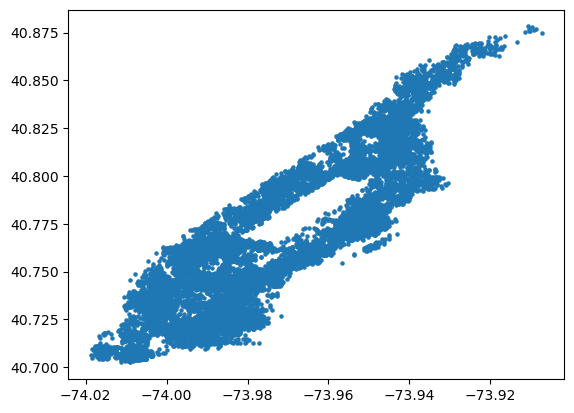

In [5]:
# insert your code here
listing['x'] = listing['geometry'].x
listing['y'] = listing['geometry'].y
X=listing[["x", "y"]]
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=5);

After correctly specifying X, use the KMeans module to quickly identify the clusters. Use `random` initialization, run `100` times of K-means algorithm around each centroid and specify `n_clusters` as 10 (2 pts)

Hint: You can refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) provided to learn how to add these parameters.

In [6]:
# insert your code here
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10,init='random',n_init=100)
np.random.seed(1234)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Create a plot to display your clustering results. Include the following:
- Clustered listing points, with marker size as 5. (2 pts)
- Centroids, with marker size as 10. (2 pts)
- Colored NTAs, with a grey edge color and 40% transparency. (2 pts) 

/Users/tangjiaxuan/opt/anaconda3/envs/gds_py/lib/python3.9/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


<AxesSubplot: >

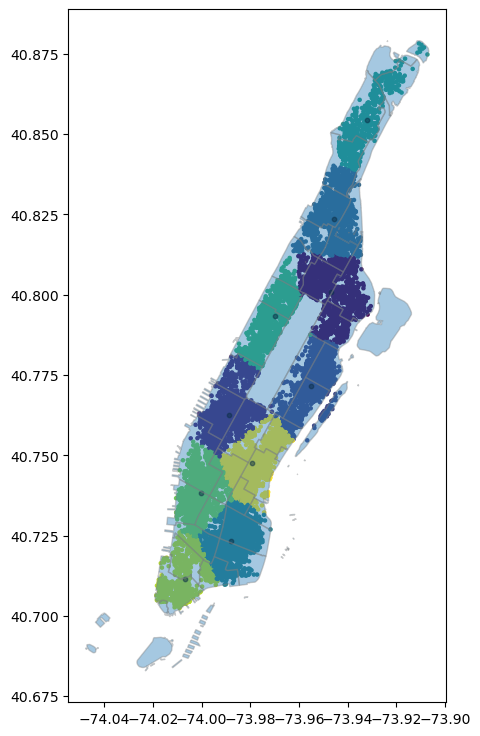

In [7]:
# insert your code here
fig1, ax1 = plt.subplots(figsize=(9, 9))
ax1.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=5, cmap='viridis')

# Generate NTAs
ntas = ct.dissolve(by='nta2020', aggfunc='sum')

centers = kmeans.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5);
ntas.plot(ax=ax1, alpha=0.4, edgecolor='grey')

Based on the above steps, define a function `find_cluster()` with parameters `k` with output as the clustering result plot. (2 pts)

In [8]:
def find_cluster(k_cluster):
    # insert your code here
    kmeans = KMeans(n_clusters=k_cluster,init='random',n_init=100)
    np.random.seed(1234)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    fig1, ax1 = plt.subplots(figsize=(9, 9))
    ax1.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=5, cmap='viridis')
    centers = kmeans.cluster_centers_
    ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5);
    ntas.plot(ax=ax1, alpha=0.4, edgecolor='grey')

Use `find_cluster()` function to experiment with 5 different numbers of `k_cluster`. Present your plots below. (2 pts)

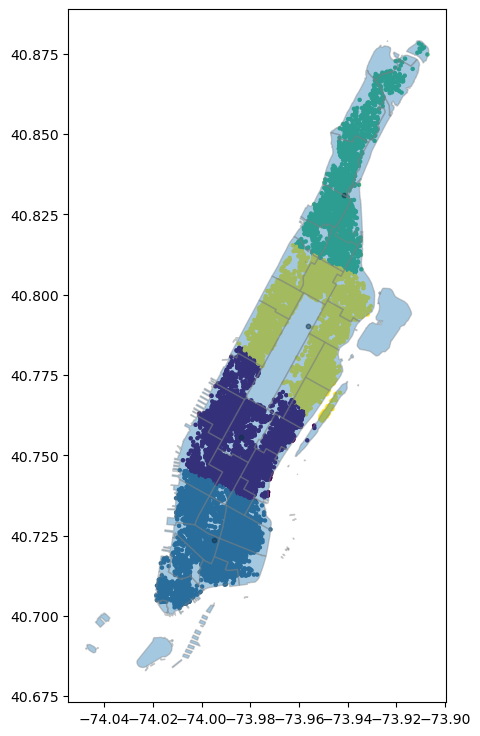

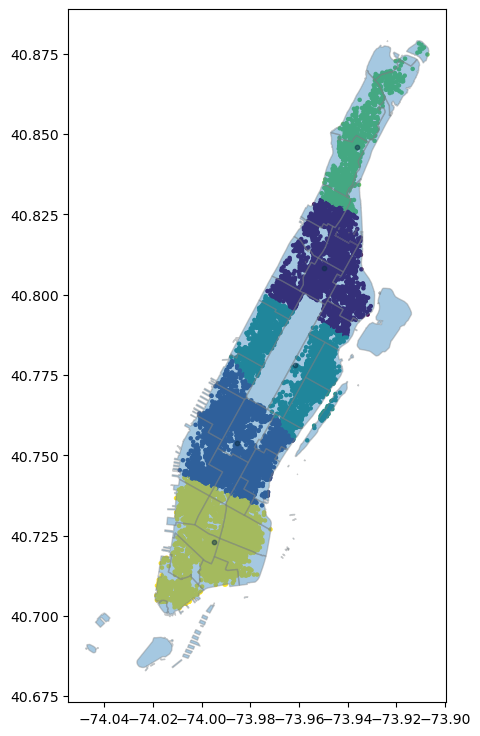

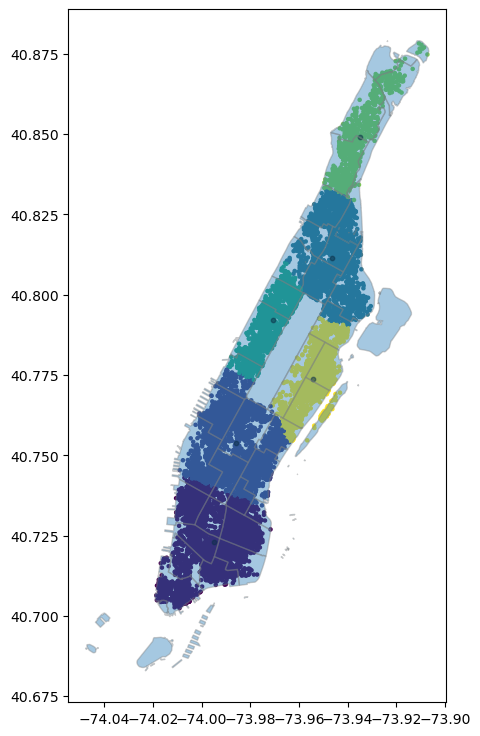

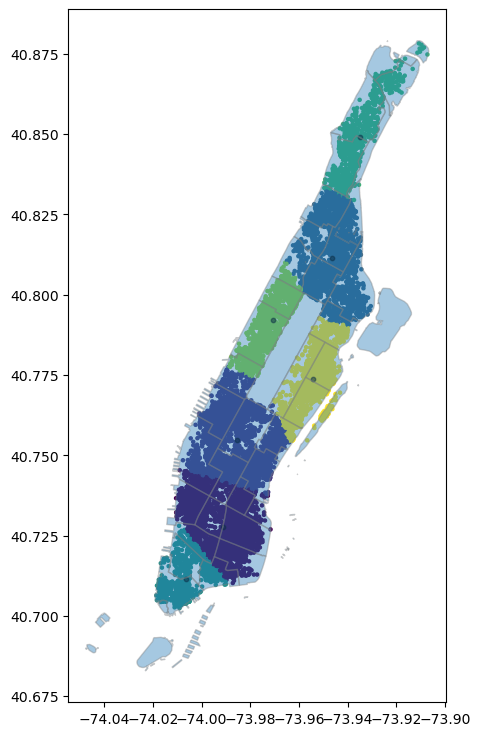

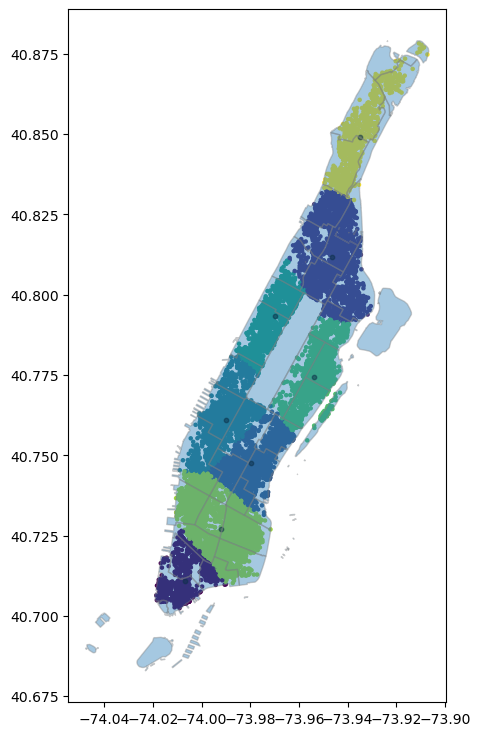

In [9]:
# insert your code here
find_cluster(4)
find_cluster(5)
find_cluster(6)
find_cluster(7)
find_cluster(8)

Compare the 6 clustering results. How do you interpret any discrepancies among them? How does the number of clusters influence the results? Also, discuss the implications of these results for future analyses that use the K-means algorithm. (2 pts)

Use markdown to write your answer.

Answer:

The major discrepancy among the results is the number of clusters (and therefore, the location of the centroids). Actually, because of the nature of the K-means algorithm, we set the number of clusters ahead of running it (the k). And the algorithm will give us the exact number of clusters we asked for no matter in what shape the data is like (as K-means is a supervised ML method). Therefore, in real-world analysis, if we need to use K-means as a way to discover the clusters, we have to know exactly who many clusters we want. If we don't know the best number of clusters, then we should try differnt k and run it for multiple times to get the best result fitting our needs.

### 2.2  Density-based Clustering Algorithm (DBSCAN) (18 pts)
Next, you will use DBSCAN algorithm to the same listing dataset and explore the difference between DBSCAN and K-means.

To conduct DBSCAN, you first need to specify `eps` and `min_samples` parameters. `eps` refers to the maximum distance between two samples for one to be considered as in the neighborhood of the other in radians rather than kilometers. Use the given equation to transform 8 kilometers into radians. 

`min_samples` refers to the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. You will use 20 listings in this exercise as the minimum number of samples. (2 pts)

Hint: more details on DBSCAN can be found in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). 

In [10]:
import pointpats
from sklearn.cluster import DBSCAN
import seaborn

# def find_clusters(listing, eps_km, weights = None, name = None):
km = 8
epsilon = km / 6371.0088
minp = 20

Use `epsilon` and `minp` in the previous step for the DBSCAN function. Specify sample weight as the `price` in listing. Next, add the cluster labels to listing as a new column `lbls`. (2 pts)

In [11]:
# insert your code here
# Define DBSCAN
clusterer = DBSCAN(eps=epsilon, min_samples=int(minp))
# Fit to our data
X = (listing[["x", "y"]])
clusterer.fit(X,sample_weight=listing['price'])

DBSCAN(eps=0.001255688110178093, min_samples=20)

In [12]:
# Turn labels into a Series
lbls = pd.Series(clusterer.labels_, index=listing.index)
# Add to listing
listing['lbls'] = lbls

How many clusters have been classified? (2 pts)

In [13]:
set(clusterer.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78}

In [14]:
len(set(clusterer.labels_))

80

In [15]:
count_of_clusters = len(set(clusterer.labels_))-1
count_of_clusters

79

In [16]:
## Note: Since we have 80 different labels including -1 noise which represents 'not belong to any of the clusters'. Therefore we have 79 clusters in total.

Plot the clustering results. Please include:
- The unclassified points (noise) in grey and size as 5. (2 pts)
- The clustered points in different colors and size as 10 (hint: check the [seaborn.scatterplot documentation](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) and specify parameter *hue* as `lbls`). Make sure to turn `lbls` into strings so that they are not read as continuous variables (2 pts)
- Base map and title. (2 pts)

/var/folders/_7/lymm6gzn0cd9kkph02m8lhsc0000gn/T/ipykernel_46228/2240208421.py:4: UserWarning: 
The palette list has fewer values (1) than needed (80) and will cycle, which may produce an uninterpretable plot.
  seaborn.scatterplot(ax=ax1, data=listing, x=listing['x'][listing['lbls']==-1], y=listing['y'][listing['lbls']==-1],hue=lbls.astype(str),s=5,legend=False,palette=['grey'])


Text(0.5, 1.0, 'Clustering Result of NYC Airbnb Listings Using DBSCAN - Estimated number of clusters: 79')

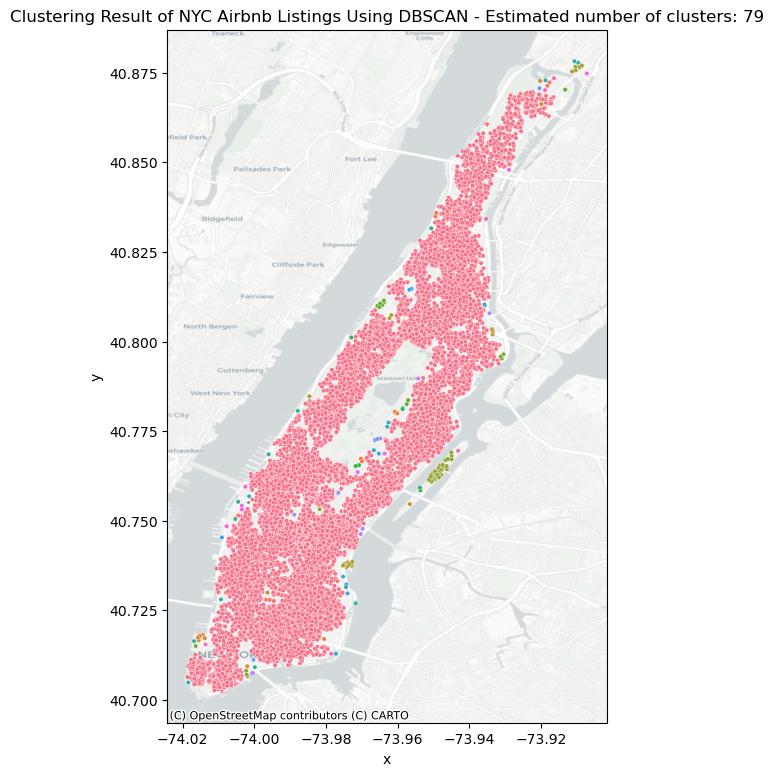

In [17]:
noise = listing.loc[lbls == -1, ["x", "y"]]
fig1, ax1 = plt.subplots(figsize=(9, 9))
# Plot the noise
seaborn.scatterplot(ax=ax1, data=listing, x=listing['x'][listing['lbls']==-1], y=listing['y'][listing['lbls']==-1],hue=lbls.astype(str),s=5,legend=False,palette=['grey'])
# Plot the clusters
seaborn.scatterplot(ax=ax1, data=listing, x=listing['x'][listing['lbls']!=-1], y=listing['y'][listing['lbls']!=-1],hue=lbls.astype(str),s=10,legend=False)
# Add basemap
import contextily as ctx
ctx.add_basemap(
    ax1, source=ctx.providers.CartoDB.Positron,
    crs=4326
)
plt.title(f"Clustering Result of NYC Airbnb Listings Using DBSCAN - Estimated number of clusters: {count_of_clusters}")

Try a different `epsilon` with everything else the same. Plot your results in the same format. (2 pts)

/var/folders/_7/lymm6gzn0cd9kkph02m8lhsc0000gn/T/ipykernel_46228/687911922.py:20: UserWarning: 
The palette list has fewer values (1) than needed (2828) and will cycle, which may produce an uninterpretable plot.
  seaborn.scatterplot(ax=ax2, data=listing, x=listing['x'][listing['lbls_1']==-1], y=listing['y'][listing['lbls_1']==-1],hue=lbls_1.astype(str),s=5,legend=False,palette=['grey'])


Text(0.5, 1.0, 'Clustering Result of NYC Airbnb Listings Using DBSCAN - Estimated number of clusters: 2827')

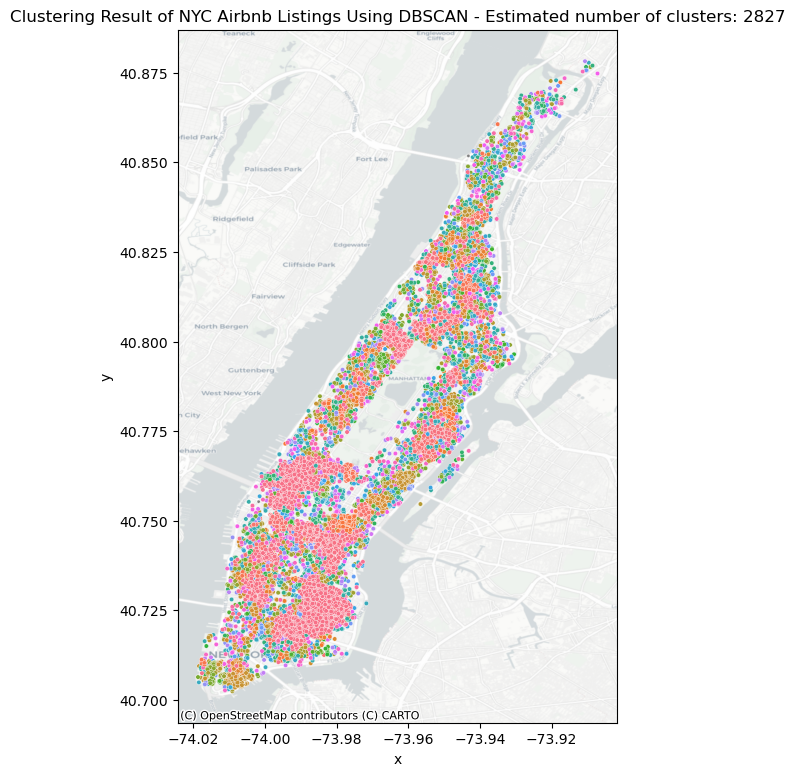

In [18]:
# We change km_1 from 8 to 16
km_1 = 3
epsilon_1 = km_1 / 6371.0088
minp_1 = 20
# insert your code here
# Define DBSCAN
clusterer_1 = DBSCAN(eps=epsilon_1, min_samples=int(minp_1))
# Fit to our data
X = (listing[["x", "y"]])
clusterer_1.fit(X,sample_weight=listing['price'])
# Turn labels into a Series
lbls_1 = pd.Series(clusterer_1.labels_, index=listing.index)
# Add to listing
listing['lbls_1'] = lbls_1
# Count the clusters
count_of_clusters_1 = len(set(clusterer_1.labels_)) - 1
noise_1 = listing.loc[lbls_1 == -1, ["x", "y"]]
fig2, ax2 = plt.subplots(figsize=(9, 9))
# Plot the noise
seaborn.scatterplot(ax=ax2, data=listing, x=listing['x'][listing['lbls_1']==-1], y=listing['y'][listing['lbls_1']==-1],hue=lbls_1.astype(str),s=5,legend=False,palette=['grey'])
# Plot the clusters
seaborn.scatterplot(ax=ax2, data=listing, x=listing['x'][listing['lbls_1']!=-1], y=listing['y'][listing['lbls_1']!=-1],hue=lbls_1.astype(str),s=10,legend=False)
# Add basemap
import contextily as ctx
ctx.add_basemap(
    ax2, source=ctx.providers.CartoDB.Positron,
    crs=4326
)
plt.title(f"Clustering Result of NYC Airbnb Listings Using DBSCAN - Estimated number of clusters: {count_of_clusters_1}")

Compare the two DBSCAN results obtained using different epsilon values and determine which one is a better reflection of the neighborhoods in Manhattan. Discuss the implications of your findings for future DBSCAN analyses. (2 pts) Use a markdown for your answer.

Answer: Comparing when k = 8 and when k = 4 and keep MinPts fixed to 20, we can see a smaller k will bring smaller clusters and more clusters. Therefore, to distinguish the neighborhood hotspots of Airbnb listing in Manhattan, using k = 4 and pick the big clusters seems to be a better option since it will help us focus more on limited areas. k = 8 will lead to a bigger cluster that covers more lands and may be pointless for an analysis.

In fact, to specify the best k and MinPts, we should try multiple combinations of both parameters to find the best result that meets our need. It depends on whether you want the result to be more focused on very limited area thus define them as key hotspots, or you want to cover more area in more bigger clusters, which can serve as a way to divide the data into parts and keep the noise minimal - the parameters are based on your need in your research, and the best parameters come from multiple attempts.

Compare the clustering results obtained in section 2.1 and 2.2. List several pros and cons of the two K-Means implementation methods. (2 pts) Use a markdown for your answer.